### Load Packages

In [1]:
import sys
from pathlib import Path

# Ensure repository root is on sys.path
_project_root = None
_here = Path().resolve()
for candidate in [_here, *_here.parents]:
    if (candidate / "src").exists():
        _project_root = candidate
        break
if _project_root is None:
    raise RuntimeError("Could not locate project root containing 'src'")
if str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))

import torch
from torch.utils.data import DataLoader

from src.data.things_dataset import ThingsDataset

from src.perturbations.perturbation_utils import PerturbationStrategy, TargetNoisePerturbation, LabelShufflePerturbation, ImageNoisePerturbation, UniformImagePerturbation, NoPerturbation

### View how the input image perturbations affect the images.

In [37]:
# Demo: load THINGS batch and print each perturbation output
# Adjust these paths to point to your local THINGS annotations and images.
img_annotations_file = Path('/home/wallacelab/Documents/GitHub/cvpr_perturbations/data/spose_embedding66d_rescaled_1806train.csv')
img_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/cvpr_perturbations/clip_hba_behavior/Data/Things1854')

assert img_annotations_file.exists(), f"Annotations not found: {img_annotations_file}"
assert img_dir.exists(), f"Image directory not found: {img_dir}"

# Small batch for quick inspection
batch_size = 4
perturb_epoch = 0
perturb_length = 1
perturb_seed = 42
perturb_type = 'random_target'

dataloader_generator = torch.Generator()
dataloader_generator.manual_seed(perturb_seed)

dataset = ThingsDataset(img_annotations_file, img_dir)
data_loader = DataLoader(dataset, batch_size, shuffle=False, generator=dataloader_generator)

# compute global target stats once (needed for TargetNoise)
target_array = torch.tensor(
    dataset.annotations.iloc[:, 1:].values.astype('float32'),
    dtype=torch.float32,
)
flat_targets = target_array.flatten()
global_target_mean = flat_targets.mean()
global_target_std = flat_targets.std(unbiased=False)

def preview_perturbation(strategy, label: str):
    names, images, targets = next(iter(data_loader))
    device = torch.device('cpu')
    images = images.to(device)
    targets = targets.to(device)
    perturbed_images, perturbed_targets = strategy.apply_to_batch(
        images, targets, device=device, epoch_idx=perturb_epoch, batch_idx=0
    )

    print(f"\n=== {label} ===")
    print(f"Original images shape: {images.shape}\nOriginal targets shape: {targets.shape}")
    print(f"Perturbed images shape: {perturbed_images.shape}\nPerturbed targets shape: {perturbed_targets.shape}")
    for i in range(4):
        print(f"Name: {names[i]}")
        print(f"Original image data:\n{images[i, :,:5, :5]}")
        print(f"Perturbed image data:\n{perturbed_images[i, :,:5, :5]}")
        print(f"Original target data:\n{targets[i]}")
        print(f"Perturbed target data:\n{perturbed_targets[i]}")

        print(f"targets mean/std (before): {targets.mean():.4f}/{targets.std(unbiased=False):.4f}")
        print(f"targets mean/std (after):  {perturbed_targets.mean():.4f}/{perturbed_targets.std(unbiased=False):.4f}")
    if not torch.equal(images, perturbed_images):
        diff = (perturbed_images - images).abs().mean()
        print(f"image mean abs diff: {diff:.6f}")

Instantiate and preview each perturbation type

In [40]:
preview_perturbation(
    NoPerturbation(perturb_epoch, perturb_length, perturb_seed),
    'NoPerturbation (control)',
)


=== NoPerturbation (control) ===
Original images shape: torch.Size([4, 3, 224, 224])
Original targets shape: torch.Size([4, 66])
Perturbed images shape: torch.Size([4, 3, 224, 224])
Perturbed targets shape: torch.Size([4, 66])
Name: aardvark_01b.jpg
Original image data:
tensor([[[-0.2435, -0.3145, -0.3287, -0.3856, -0.4140],
         [-0.2435, -0.3003, -0.3714, -0.3998, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4140, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4424, -0.4566],
         [-0.2719, -0.3145, -0.4140, -0.4708, -0.4850]],

        [[-0.2592, -0.3182, -0.3625, -0.4362, -0.4657],
         [-0.2740, -0.3182, -0.4215, -0.4510, -0.4804],
         [-0.3625, -0.3625, -0.4362, -0.4657, -0.4804],
         [-0.3625, -0.3772, -0.4657, -0.4952, -0.5099],
         [-0.3330, -0.3625, -0.4804, -0.5394, -0.5542]],

        [[-0.2633, -0.4021, -0.4438, -0.5132, -0.5271],
         [-0.2771, -0.4021, -0.4993, -0.5271, -0.5410],
         [-0.3466, -0.4438, -0.5410, -0.5410, -0.541

In [4]:
preview_perturbation(
    TargetNoisePerturbation(
        perturb_epoch,
        perturb_length,
        perturb_seed,
        target_mean=global_target_mean,
        target_std=global_target_std,
    ),
    'TargetNoisePerturbation',
)


=== TargetNoisePerturbation ===
Original images shape: torch.Size([4, 3, 224, 224])
Original targets shape: torch.Size([4, 66])
Perturbed images shape: torch.Size([4, 3, 224, 224])
Perturbed targets shape: torch.Size([4, 66])
Name: aardvark_01b.jpg
Original image data:
tensor([[[-0.2435, -0.3145, -0.3287, -0.3856, -0.4140],
         [-0.2435, -0.3003, -0.3714, -0.3998, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4140, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4424, -0.4566],
         [-0.2719, -0.3145, -0.4140, -0.4708, -0.4850]],

        [[-0.2592, -0.3182, -0.3625, -0.4362, -0.4657],
         [-0.2740, -0.3182, -0.4215, -0.4510, -0.4804],
         [-0.3625, -0.3625, -0.4362, -0.4657, -0.4804],
         [-0.3625, -0.3772, -0.4657, -0.4952, -0.5099],
         [-0.3330, -0.3625, -0.4804, -0.5394, -0.5542]],

        [[-0.2633, -0.4021, -0.4438, -0.5132, -0.5271],
         [-0.2771, -0.4021, -0.4993, -0.5271, -0.5410],
         [-0.3466, -0.4438, -0.5410, -0.5410, -0.5410

In [8]:
preview_perturbation(
    LabelShufflePerturbation(perturb_epoch, perturb_length, perturb_seed),
    'LabelShufflePerturbation',
)


=== LabelShufflePerturbation ===
Original images shape: torch.Size([4, 3, 224, 224])
Original targets shape: torch.Size([4, 66])
Perturbed images shape: torch.Size([4, 3, 224, 224])
Perturbed targets shape: torch.Size([4, 66])
Name: aardvark_01b.jpg
Original image data:
tensor([[[-0.2435, -0.3145, -0.3287, -0.3856, -0.4140],
         [-0.2435, -0.3003, -0.3714, -0.3998, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4140, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4424, -0.4566],
         [-0.2719, -0.3145, -0.4140, -0.4708, -0.4850]],

        [[-0.2592, -0.3182, -0.3625, -0.4362, -0.4657],
         [-0.2740, -0.3182, -0.4215, -0.4510, -0.4804],
         [-0.3625, -0.3625, -0.4362, -0.4657, -0.4804],
         [-0.3625, -0.3772, -0.4657, -0.4952, -0.5099],
         [-0.3330, -0.3625, -0.4804, -0.5394, -0.5542]],

        [[-0.2633, -0.4021, -0.4438, -0.5132, -0.5271],
         [-0.2771, -0.4021, -0.4993, -0.5271, -0.5410],
         [-0.3466, -0.4438, -0.5410, -0.5410, -0.541

In [7]:
preview_perturbation(
    ImageNoisePerturbation(perturb_epoch, perturb_length, perturb_seed),
    'ImageNoisePerturbation',
)


=== ImageNoisePerturbation ===
Original images shape: torch.Size([4, 3, 224, 224])
Original targets shape: torch.Size([4, 66])
Perturbed images shape: torch.Size([4, 3, 224, 224])
Perturbed targets shape: torch.Size([4, 66])
Name: aardvark_01b.jpg
Original image data:
tensor([[[-0.2435, -0.3145, -0.3287, -0.3856, -0.4140],
         [-0.2435, -0.3003, -0.3714, -0.3998, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4140, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4424, -0.4566],
         [-0.2719, -0.3145, -0.4140, -0.4708, -0.4850]],

        [[-0.2592, -0.3182, -0.3625, -0.4362, -0.4657],
         [-0.2740, -0.3182, -0.4215, -0.4510, -0.4804],
         [-0.3625, -0.3625, -0.4362, -0.4657, -0.4804],
         [-0.3625, -0.3772, -0.4657, -0.4952, -0.5099],
         [-0.3330, -0.3625, -0.4804, -0.5394, -0.5542]],

        [[-0.2633, -0.4021, -0.4438, -0.5132, -0.5271],
         [-0.2771, -0.4021, -0.4993, -0.5271, -0.5410],
         [-0.3466, -0.4438, -0.5410, -0.5410, -0.5410]

In [9]:
preview_perturbation(
    UniformImagePerturbation(perturb_epoch, perturb_length, perturb_seed),
    'UniformImagePerturbation',
)


=== UniformImagePerturbation ===
Original images shape: torch.Size([4, 3, 224, 224])
Original targets shape: torch.Size([4, 66])
Perturbed images shape: torch.Size([4, 3, 224, 224])
Perturbed targets shape: torch.Size([4, 66])
Name: aardvark_01b.jpg
Original image data:
tensor([[[-0.2435, -0.3145, -0.3287, -0.3856, -0.4140],
         [-0.2435, -0.3003, -0.3714, -0.3998, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4140, -0.4282],
         [-0.3145, -0.3287, -0.3998, -0.4424, -0.4566],
         [-0.2719, -0.3145, -0.4140, -0.4708, -0.4850]],

        [[-0.2592, -0.3182, -0.3625, -0.4362, -0.4657],
         [-0.2740, -0.3182, -0.4215, -0.4510, -0.4804],
         [-0.3625, -0.3625, -0.4362, -0.4657, -0.4804],
         [-0.3625, -0.3772, -0.4657, -0.4952, -0.5099],
         [-0.3330, -0.3625, -0.4804, -0.5394, -0.5542]],

        [[-0.2633, -0.4021, -0.4438, -0.5132, -0.5271],
         [-0.2771, -0.4021, -0.4993, -0.5271, -0.5410],
         [-0.3466, -0.4438, -0.5410, -0.5410, -0.541

### Reconstruct the perturbed images to view the perturbation strategy's effects.

In [38]:
# Helper: reconstruct and visualize an image tensor (C,H,W) normalized with THINGS stats
import matplotlib.pyplot as plt

_THINGS_MEAN = torch.tensor([0.52997664, 0.48070561, 0.41943838]).view(3, 1, 1)
_THINGS_STD = torch.tensor([0.27608301, 0.26593025, 0.28238822]).view(3, 1, 1)

def show_tensor_image(img_tensor, title="reconstructed image", ax=None):
    """Undo THINGS normalization and plot a single image tensor of shape (3,H,W)."""
    img = img_tensor.detach().cpu()
    img = img * _THINGS_STD + _THINGS_MEAN
    img = img.clamp(0, 1).permute(1, 2, 0)  # to HWC
    if ax is None:
        _, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)
    return ax

def visualize_example(idx=0, strategy=None, label=None):
    """Show one example (by index) before/after an optional perturbation strategy."""
    names, images, targets = next(iter(data_loader))
    device = torch.device('cpu')
    images = images.to(device)
    targets = targets.to(device)

    if strategy is None:
        perturbed_images, perturbed_targets = images, targets
    else:
        perturbed_images, perturbed_targets = strategy.apply_to_batch(
            images, targets, device=device, epoch_idx=perturb_epoch, batch_idx=0
        )

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    show_tensor_image(images[idx], title=f"Original: {names[idx]}", ax=axs[0])
    suffix = label if label is not None else "Perturbed"
    show_tensor_image(perturbed_images[idx], title=suffix, ax=axs[1])
    plt.tight_layout()
    plt.show()

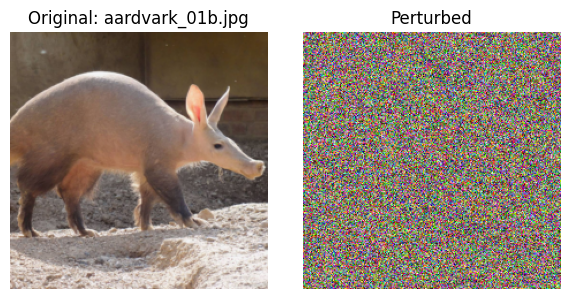

In [ ]:
# Example: pass only the image index (and optionally a strategy) to change what is shown
visualize_example(
    idx=0,
    strategy=ImageNoisePerturbation(perturb_epoch, perturb_length, perturb_seed),  # e.g., TargetNoisePerturbation(...)
    label="Perturbed",
)